In [1]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
import fasttext
import numpy as np
from numpy.linalg import norm
import string

In [3]:
from word_vectors.read import read
from word_vectors import FileType

In [104]:
import random
from itertools import islice

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

from sklearn.model_selection import train_test_split

device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)

In [5]:
data_dir = "data"

# append to df with label
def add_to_df(dataframe, label, file_name):
    with open(Path(data_dir)/file_name) as f:
        for line in f.readlines():
            new_row = pd.DataFrame([ [line.strip(), label] ], columns=dataframe.columns)
            dataframe = pd.concat([new_row, dataframe], ignore_index=True)
    return dataframe

df = pd.DataFrame(columns=["review", "label"])
files = os.listdir(data_dir)

# assign labels based on file name
for file in files:
    if "positive" in file.lower():
        df = add_to_df(df, 1, file)
    elif "negative" in file.lower():
        df = add_to_df(df, 0, file)

In [6]:
drop_idxs = df[df.review==''].index
df.drop(drop_idxs, inplace=True)

[]

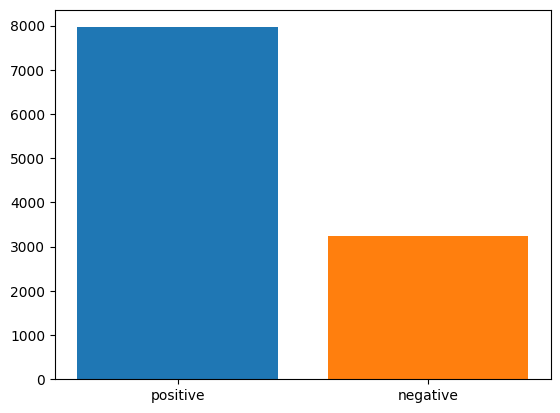

In [7]:
fig, ax = plt.subplots()
ax.bar("positive", df.loc[df.label == 1].count())
ax.bar("negative", df.loc[df.label == 0].count())
plt.plot()

In [8]:
model = fasttext.load_model("wiki-news-300d-1M-subword.bin")

In [9]:
class ReviewsClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(300, 800)
        self.linear2 = nn.Linear(800, 200)
        self.linear3 = nn.Linear(200, 1)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x

In [10]:
class Dataset:
    def __init__(self, df, proc_fn): self.df, self.proc_fn = df, proc_fn
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        return tensor(self.proc_fn(df.review.iloc[i]), device=device), tensor(self.df.label.iloc[i], dtype=torch.float32, device=device)

class DataLoader:
    def __init__(self, ds, batches, collate_fn):
        self.ds = ds
        self.batches = batches
        self.collate_fn = collate_fn
        
    def __iter__(self):
        yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batches)

class Sampler:
    def __init__(self, ds, shuffle=True): self.n, self.shuffle = len(ds), shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

class BatchSampler:
    def __init__(self, sampler, bs, drop_last=False): self.sampler, self.bs, self.drop_last = sampler, bs, drop_last
    def __iter__(self):
        yield from chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [11]:
# get and collate (x, y) elements provided a batch of indices
def collate(b):
    xs, y = zip(*b)
    return torch.stack(xs), torch.stack(y)

In [12]:
bsz = 64

In [99]:
trn, test = train_test_split(df, train_size=0.9, random_state=42, shuffle=True, stratify=df.label)

sv = model.get_sentence_vector
trn_ds, test_ds = Dataset(trn, sv), Dataset(test, sv)

# trn_batches = BatchSampler(Sampler(trn_ds, shuffle=True), bsz)
# val_batches = BatchSampler(Sampler(val_ds, shuffle=True), bsz)

# trn_dl = DataLoader(trn_ds, trn_batches, collate)
# val_dl = DataLoader(val_ds, val_batches, collate)

In [100]:
def cust_collate(b):
    xs, y = zip(*b)
    return torch.stack(xs), torch.stack(y)

In [101]:
torch.manual_seed(69)
classifier = ReviewsClassifier().to(device)
loss_fn = nn.BCELoss()

lossi = []
stepi = []

In [77]:
lr = 0.01
optimizer = optim.SGD(classifier.parameters(), lr=lr, momentum=0.7)
scheduler = LambdaLR(optimizer, lr_lambda=[lambda epoch: ])

In [17]:
trn_collated_xs, trn_collated_y = cust_collate(trn_ds)
val_collated_xs, val_collated_y = cust_collate(val_ds)

def calc_loss(xs, y):
    preds = classifier(xs)
    return loss_fn(preds, y.unsqueeze(-1))

def get_loss(split: str):
    if split == "trn":
        return calc_loss(trn_collated_xs, trn_collated_y)
    else:
        return calc_loss(val_collated_xs, val_collated_y)

In [18]:
trn_collated_xs.shape, val_collated_xs.shape

(torch.Size([8968, 300]), torch.Size([2242, 300]))

In [30]:
ds = Dataset(df, sv)
full_xs, full_y = cust_collate(ds)

In [20]:
idxs = torch.randint(0, len(trn_ds), (bsz, ), device=device)
xs, y = trn_collated_xs[idxs], trn_collated_y[idxs]

In [21]:
torch.nonzero(trn_collated_y[idxs]).shape

torch.Size([42, 1])

In [82]:
for i in range(10000):
    idxs = torch.randint(0, len(ds), (bsz, ), device=device)
    # xs, y = (trn_collated_xs[idxs], trn_collated_y[idxs])
    xs, y = full_xs[idxs], full_y[idxs]
    optimizer.zero_grad()
    preds = classifier(xs)
    loss_w = loss_fn(preds, y.unsqueeze(-1))
    loss_w.backward()
    optimizer.step()

    if i > 100000:
        
    if i % 100 == 0:
    #     with torch.no_grad():
    #         trn_loss = get_loss("trn")
    #         val_loss = get_loss("val")
        print(f"Epoch: {i}; Loss: {loss_w}")
    lossi.append(loss_w.item())

Epoch: 0; Loss: 0.17806491255760193
Epoch: 100; Loss: 0.1954050213098526
Epoch: 200; Loss: 0.03775699436664581
Epoch: 300; Loss: 0.10854121297597885
Epoch: 400; Loss: 0.04881683364510536
Epoch: 500; Loss: 0.09797021746635437
Epoch: 600; Loss: 0.11752130091190338
Epoch: 700; Loss: 0.035540059208869934
Epoch: 800; Loss: 0.09028282016515732
Epoch: 900; Loss: 0.1732087880373001
Epoch: 1000; Loss: 0.043521031737327576
Epoch: 1100; Loss: 0.08361829072237015
Epoch: 1200; Loss: 0.0779242217540741
Epoch: 1300; Loss: 0.05529097467660904
Epoch: 1400; Loss: 0.1400676667690277
Epoch: 1500; Loss: 0.06470827758312225
Epoch: 1600; Loss: 0.10290267318487167
Epoch: 1700; Loss: 0.052127905189991
Epoch: 1800; Loss: 0.16899357736110687
Epoch: 1900; Loss: 0.13190589845180511
Epoch: 2000; Loss: 0.07056650519371033
Epoch: 2100; Loss: 0.133524551987648
Epoch: 2200; Loss: 0.05451710522174835
Epoch: 2300; Loss: 0.09841106086969376
Epoch: 2400; Loss: 0.06448061764240265
Epoch: 2500; Loss: 0.050996556878089905
Epo

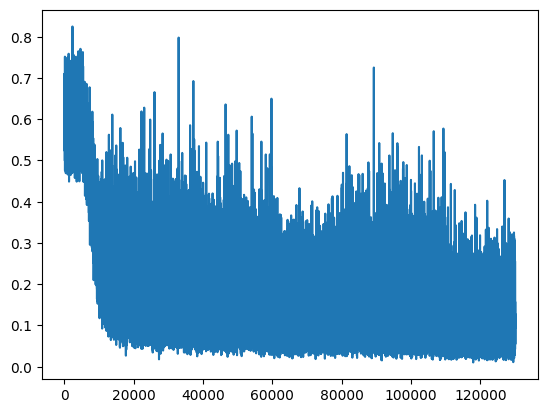

In [83]:
plt.plot(range(len(lossi)), lossi)

In [84]:
min(lossi)

0.01028359867632389

In [93]:
def inference(inp):
    with torch.no_grad():
        p = classifier(tensor(model.get_sentence_vector(inp)))
        return p.item()

In [95]:
inference("The shirts came out are ok, VERY bunched embroidery. The pricing on this website makes no sense at all. It seems to change every day and it's incredibly frustrating. Their marketing team needs to take a chill pill and stop sending 100 emails per week. For us it's just not worth it to \"shop small\" anymore, our orders from custom ink have been faster and higher quality.")

0.0185760036110878

In [96]:
inference("These people are so stupid they cant even get your billing info correct, I need my shirts and they were suppose to be here on May, 10th they acually shipped it thru USPS instead of Ups, they lied and I do not recommend this company for anything.")

0.0016490574926137924

In [97]:
inference("Product was as described and delivered in a timely manner.")

0.9050244092941284

In [98]:
inference("Enjoy Queensboro products and have ordered multiple times. I had expectations with an Order on Dec 1st, logo approved Dec 5th that it would arrive by Christmas. Unfortunately, it shipped Dec 30th and received January 4th. Would be nice to have more communication of when to expect versus just \"in line for production\" or \"in production\" as it was \"in production for what seemed like a week or more. Service has always been excellent.")

0.8924559950828552